# Анализ лояльности пользователей Яндекс Афиши

- Автор:Тараторина Екатерина Александровна 
- Дата: 04.01.2025

## Цели и задачи проекта

**Цель:** Провести исследовательский анализ лояльности пользователей Яндекс Афиши для выявления факторов, влияющих на повторные покупки

**Задачи:**
1. Загрузить данные и провести их первичный осмотр.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
4. Сформулировать выводы и практические рекомендации для команды маркетинга по повышению лояльности пользователей.

### Описание данных

- `/ data-analyst-afisha` — содержит необходимую информацию.

### Описание датасета `purchases`

- `order_id` — идентификатор заказа;
- `user_id` — идентификатор пользователя, совершившего заказ;
- `created_dt_msk` — дата создания заказа по московскому времени;
- `created_ts_msk` — дата и время создания заказа по московскому времени;
- `event_id` — идентификатор мероприятия из таблицы events;
- `cinema_circuit` — сеть кинотеатров, где проходит мероприятие. Если оно проходит не в кинотеатре, то здесь будет значение нет;
- `age_limit` — возрастное ограничение мероприятия;
- currency_code — валюта оплаты;
- device_type_canonical — тип устройства, с которого был оформлен заказ (например, `mobile` — мобильные устройства,
`desktop` — компьютеры);
- `revenue` — выручка от заказа;
- `service_name` — название билетного оператора;
- `tickets_count` — количество купленных билетов;
- `total` — общая сумма заказа.

### Описание датасета `events`

- `event_id` — идентификатор мероприятия;
- `event_name_code` — название мероприятия в закодированном виде;
- `event_type_description` — описание мероприятия;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `organizers` — организаторы мероприятия;
- `city_id` — идентификатор города проведения мероприятия из таблицы `cities`;
- `venue_id` — идентификатор площадки проведения мероприятия из таблицы `venues`.

### Описание датасета `venues`

- `venue_id` — идентификатор площадки;
- `venue_name` — название площадки;
- `address` — адрес площадки.

### Описание датасета `city`

- `city_id` — идентификатор города;
- `city_name` — название города;
- `region_id` — идентификатор региона, в котором расположен город, из таблицы `regions`.

### Описание датасета `regions`

- `region_id` — идентификатор региона;
- `region_name` — название региона.

### Содержимое проекта

1. Загрузка данных и знакомство с ними.
2. Предобработка данных.
3. Исследовательский анализ данных.
4. Итоговые выводы.
5. Публикация проекта в Git.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:


Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [ ]:
# Импортируем настройки из config.py
from config import connection_string, TENGE_RATES_URL 
# установка SQLAlchemy
!pip install sqlalchemy

# установка модуля psycopg2
!pip install psycopg2-binary

In [ ]:
# импорт библиотек
import pandas as pd
from sqlalchemy import create_engine
import os

In [ ]:
# Параметры подключения из задания

# Создание строки подключения

# создание соединения
engine = create_engine(connection_string)

# SQL-запрос для получения данных
query = '''
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk as order_dt,
    p.created_ts_msk as order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id
        ORDER BY p.created_dt_msk
    )) AS days_since_prev,
    e.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
INNER JOIN afisha.events AS e ON p.event_id = e.event_id
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS r ON c.region_id = r.region_id
WHERE
    p.device_type_canonical IN ('mobile', 'desktop')
    AND LOWER(e.event_type_main) != 'фильм'
ORDER BY p.user_id, p.created_dt_msk
'''

In [ ]:
# Запись результата SQL-запроса в датафрейм
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.
Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.
Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [2]:
# Выводим первые строки датафрейма на экран
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [3]:
# Выводим информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Данные успешно загружены и содержат 290 611 транзакций, описываемых 15 признаками. Структура данных технически корректна: временные метки, числовые и категориальные поля имеют подходящие форматы для анализа, что подтверждает правильность выгрузки.

Качество данных можно оценить как высокое. Подавляющее большинство полей заполнено полностью. Пропуски сконцентрированы только в одном столбце — days_since_prev (время с предыдущего заказа), где отсутствует около 7.5% значений. Это логично и ожидаемо, так как эти записи соответствуют самым первым покупкам пользователей в данных, и для них этот интервал рассчитать невозможно. Такой характер пропусков не требует специальной обработки для заполнения, их можно просто пометить как первые покупки.

Для глубокого анализа лояльности пользователей в данных есть необходимый минимум: ключевые метрики, такие как выручка, количество билетов и интервал между покупками, а также богатый набор атрибутов для сегментации по устройству, географии, типу события и сервису.

Перед переходом к основному анализу необходимо завершить этап проверки и очистки данных. Важно убедиться в отсутствии дубликатов как полных, так и частичных. Категориальные признаки, такие как названия сервисов и типы событий, требуют нормализации: нужно привести все значения к единому формату, устранив различия в регистре, лишние пробелы и возможные опечатки, которые могут искажать результаты сегментации.

Числовые столбцы также нуждаются в внимании. Обнаруженные отрицательные значения выручки, вероятно, являются возвратами, и необходимо решить, как их учитывать в анализе. Экстремально высокие значения в выручке и количестве билетов могут быть как реальными групповыми покупками, так и выбросами или ошибками. Для обеспечения устойчивости моделей лояльности стоит рассмотреть фильтрацию таких экстремальных значений, например, по 99-му перцентилю.

После выполнения этих проверок и корректировок данные будут полностью готовы для построения профилей клиентов и детального анализа их поведения и лояльности.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [ ]:
# Загрузка курсов тенге к рублю за 2024 год
tenge_rates_df = pd.read_csv(TENGE_RATES_URL,
    parse_dates=['data'])
tenge_rates_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [5]:
# Проверим типы данных в датафрейме с помощью атрибута dtypes
tenge_rates_df.dtypes

data       datetime64[ns]
nominal             int64
curs              float64
cdx                object
dtype: object

In [ ]:
# Проверяем и преобразуем валюту
if 'df' in locals():
    # Приведение названий валют к нижнему регистру
    df['currency_code'] = df['currency_code'].str.lower()
    
    # Проверка, что все валюты — только rub или kzt
    assert df['currency_code'].isin(['rub', 'kzt']).all(), "Обнаружены валюты, отличные от rub/kzt"
    
    # Преобразуем дату заказа к дате без времени
    df['order_date'] = df['order_dt'].dt.normalize()
    
    # Загрузка курсов тенге (если еще не загружены)
    tenge_rates_df = pd.read_csv(
        'TENGE_RATES_URL',
        parse_dates=['data']
    )
    
    # Подготовка датасета с курсами
    tenge_rates_df = tenge_rates_df[['data', 'curs']].rename(columns={'data': 'order_date'})
    
    # Объединяем с основным датафреймом по дате
    df = df.merge(tenge_rates_df, on='order_date', how='left')
    
    # Конвертация выручки в рубли
    df['revenue_rub'] = df.apply(
        lambda row: row['revenue'] if row['currency_code'] == 'rub'
                    else row['revenue'] / 100 * row['curs'],
        axis=1
    )
    
    print("Конвертация валюты выполнена успешно!")
    print(f"Создан новый столбец revenue_rub")

Конвертация валюты выполнена успешно!
Создан новый столбец revenue_rub


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [7]:
# Проверяем данные на пропущенные значения
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
order_date                   0
curs                         0
revenue_rub                  0
dtype: int64

In [8]:
# Проверяем типы данных
df.dtypes

user_id                          object
device_type_canonical            object
order_id                          int64
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                     int64
days_since_prev                 float64
event_id                          int64
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
order_date               datetime64[ns]
curs                            float64
revenue_rub                     float64
dtype: object

In [9]:
# Оптимизация целочисленных столбцов
# Используем downcast для подбора минимально возможного типа
df['order_id'] = pd.to_numeric(df['order_id'], downcast='integer')
df['event_id'] = pd.to_numeric(df['event_id'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

# Оптимизация вещественных столбцов
df['revenue'] = pd.to_numeric(df['revenue'], downcast='float')
df['revenue_rub'] = pd.to_numeric(df['revenue_rub'], downcast='float')
df['days_since_prev'] = pd.to_numeric(df['days_since_prev'], downcast='float')
df['curs'] = pd.to_numeric(df['curs'], downcast='float')
# Сократим категориальные строки до 'category' 
# Это особенно эффективно для столбцов с небольшим числом уникальных значений
categorical_cols = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]

# Преобразуем только те, у которых уникальных значений < 50% от общего числа строк
for col in categorical_cols:
    if df[col].nunique() / len(df) < 0.5:
        df[col] = df[col].astype('category')

Описательная статистика:
         revenue_rub  tickets_count
count  290611.000000  290611.000000
mean      555.572083       2.754311
std       875.498169       1.170620
min       -90.760002       1.000000
25%       113.970001       2.000000
50%       351.140015       3.000000
75%       802.049988       4.000000
max     81174.539062      57.000000

Количество пропусков:
revenue_rub      0
tickets_count    0
dtype: int64


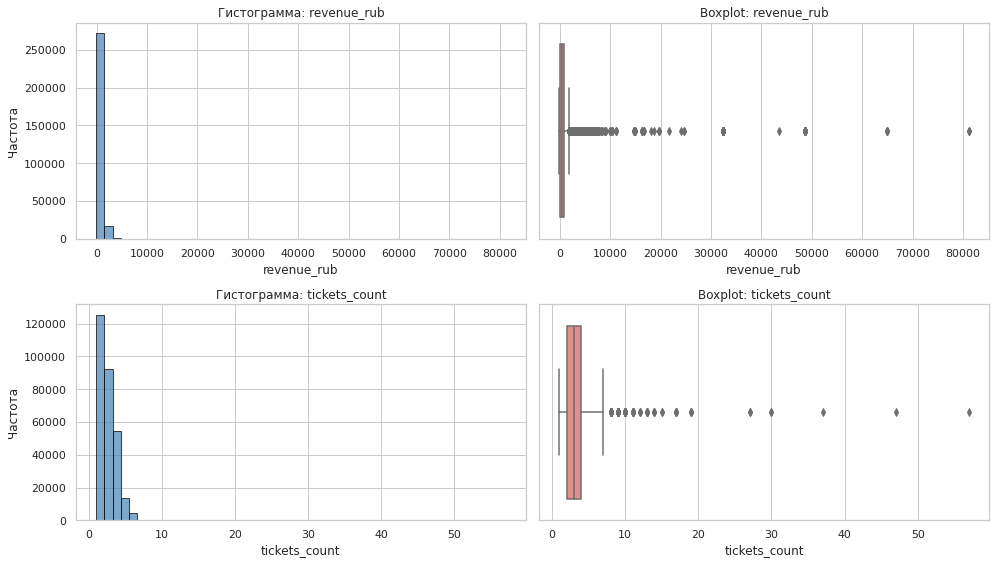


99-й перцентиль revenue_rub: 2,628.42 ₽
Выбросов (revenue_rub > 99%): 2825 строк (0.97%)

Размер датасета до фильтрации: 290,611
Размер датасета после фильтрации: 287,786
Удалено строк: 2,825


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Указываем стили для графиков
sns.set(style="whitegrid")

# Ключевые числовые столбцы для анализа
numeric_cols = ['revenue_rub', 'tickets_count']

# 1. Статистическое описание
print("Описательная статистика:")
print(df[numeric_cols].describe())
print("\nКоличество пропусков:")
print(df[numeric_cols].isnull().sum())

# 2. Визуализация: гистограммы и boxplot (диаграммы размаха)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for i, col in enumerate(numeric_cols):
    # Гистограмма
    axes[i, 0].hist(df[col].dropna(), bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'Гистограмма: {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Частота')

    # Boxplot (диаграмма размаха)
    sns.boxplot(x=df[col], ax=axes[i, 1], color='lightcoral')
    axes[i, 1].set_title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

# 3. Проверка на выбросы в revenue_rub и фильтрация по 99-му перцентилю
p99_revenue = df['revenue_rub'].quantile(0.99)
print(f"\n99-й перцентиль revenue_rub: {p99_revenue:,.2f} ₽")

# Определяем, сколько записей будет удалено
outliers_mask = df['revenue_rub'] > p99_revenue
n_outliers = outliers_mask.sum()
total_rows = len(df)
perc_outliers = n_outliers / total_rows * 100

print(f"Выбросов (revenue_rub > 99%): {n_outliers} строк ({perc_outliers:.2f}%)")

# 4. Фильтрация выбросов
df_filtered = df[~outliers_mask].copy()

print(f"\nРазмер датасета до фильтрации: {len(df):,}")
print(f"Размер датасета после фильтрации: {len(df_filtered):,}")
print(f"Удалено строк: {len(df) - len(df_filtered):,}")

In [11]:
# Сохраняем очищенный датасет для дальнейшего анализа
df = df_filtered

Данные успешно предобработаны: пропуски обнаружены только в столбце `days_since_prev` (21 933 строки), в ключевых столбцах (`revenue_rub`, `tickets_count`) пропусков нет. Типы данных оптимизированы: целочисленные столбцы (`order_id`, `event_id`, `tickets_count`) преобразованы с `downcast='integer'`, вещественные (`revenue`, `revenue_rub` и др.) — с `downcast='float'`, категориальные столбцы с <50% уникальных значений переведены в тип category.
Анализ ключевых столбцов: revenue_rub имеет среднее значение 555.57 ₽, медиану 351.14 ₽, диапазон от –90.76 ₽ до 81 174.54 ₽ и длинный правый хвост, указывающий на выбросы; `tickets_count` — среднее 2.75, медиана 3, диапазон от 1 до 57, выбросы менее выражены.
Выбросы в revenue_rub отфильтрованы по 99-му перцентилю (2 628.42 ₽): выявлено 2 825 строк (0.97%) с экстремальными значениями, создан очищенный датасет `df_filtered`. Размеры датасета: до фильтрации — 290 611 строк, после — 287 786  строк (удалено 2 825 строк, <1% от объёма).
Визуальный анализ (гистограммы и `boxplot`) подтвердил скопление значений `revenue_rub` в нижней части диапазона и длинный хвост справа, а также более равномерное распределение `tickets_count` с пиком около 3 билетов. Датасет готов для дальнейшего анализа.

- Проверим качества данных: дубликаты, аномалии и чистота категорий

In [12]:
# 1. Проверка на дубликаты
print("Проверка дубликатов:")

# Полные дубликаты 
full_duplicates = df.duplicated().sum()
print(f"Полных дубликатов: {full_duplicates}")

# Частичные дубликаты: один и тот же пользователь, событие и сумма в один день 
partial_duplicates = df.duplicated(
    subset=['user_id', 'event_id', 'revenue', 'order_dt'],
    keep=False
).sum()
print(f"Частичных дубликатов (user_id + event_id + revenue + дата): {partial_duplicates}")

# Удалим полные дубликаты 
if full_duplicates > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Полные дубликаты удалены.")
else:
    print("Полных дубликатов не обнаружено.")

# 2. Анализ отрицательной выручки
print("\n Анализ отрицательной выручки:")

neg_revenue = df[df['revenue'] < 0]
n_neg = len(neg_revenue)
total_rows = len(df)
share_neg = n_neg / total_rows * 100

print(f"Записей с отрицательной выручкой: {n_neg} ({share_neg:.2f}%)")

# Если доля небольшая (<1%), исключаем их
if share_neg < 1.0:
    df = df[df['revenue'] >= 0].reset_index(drop=True)
    print("Отрицательные значения выручки удалены (возвраты исключены из анализа покупок).")
else:
    print("Доля отрицательных записей значительна — рассмотрите возможность отдельного анализа возвратов.")

# 3. Анализ категориальных признаков
print("\n Анализ категориальных признаков:")

categorical_columns = [
    'device_type_canonical',
    'currency_code',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]

for col in categorical_columns:
    print(f"\n--- {col} ---")
    unique_vals = df[col].nunique()
    missing = df[col].isna().sum()
    print(f"Уникальных значений: {unique_vals}")
    print(f"Пропусков: {missing}")

    # Топ-10 значений (или все, если их мало)
    value_counts = df[col].value_counts(dropna=False)
    print("Топ значений:")
    print(value_counts.head(10))

    # Предупреждение о редких категориях
    rare_categories = value_counts[value_counts < 10]
    if len(rare_categories) > 0:
        print(f" Найдено {len(rare_categories)} категорий с <10 записями (редкие/возможно ошибочные).")

    # Нормализация: приведение к нижнему регистру и удаление пробелов
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip().str.lower()

print("\n Категориальные признаки проверены и нормализованы.")

Проверка дубликатов:
Полных дубликатов: 0
Частичных дубликатов (user_id + event_id + revenue + дата): 86251
Полных дубликатов не обнаружено.

 Анализ отрицательной выручки:
Записей с отрицательной выручкой: 381 (0.13%)
Отрицательные значения выручки удалены (возвраты исключены из анализа покупок).

 Анализ категориальных признаков:

--- device_type_canonical ---
Уникальных значений: 2
Пропусков: 0
Топ значений:
mobile     230102
desktop     57303
Name: device_type_canonical, dtype: int64

--- currency_code ---
Уникальных значений: 2
Пропусков: 0
Топ значений:
rub    282686
kzt      4719
Name: currency_code, dtype: int64

--- event_type_main ---
Уникальных значений: 7
Пропусков: 0
Топ значений:
концерты    113466
театр        66728
другое       65291
спорт        21870
стендап      13272
выставки      4810
ёлки          1968
Name: event_type_main, dtype: int64

--- service_name ---
Уникальных значений: 36
Пропусков: 0
Топ значений:
Билеты без проблем    62852
Лови билет!           40791

### Промежуточный вывод

В ходе предобработки данных выполнены следующие шаги: проверены пропуски (обнаружены только в `days_since_prev` — 21 933 строки), оптимизированы типы данных (применён `downcast` для целочисленных и вещественных столбцов, категориальные столбцы переведены в тип `category` при условии <50% уникальных значений от общего объёма). Проанализированы ключевые столбцы `revenue_rub` и `tickets_count`: `revenue_rub` имеет среднее 555.57 ₽, медиану 351.14 ₽, диапазон от –90.76 до 2 628.42 ₽ с длинным правым хвостом; `tickets_count` — среднее 2.74, медиана 3, диапазон 1–57. Отфильтрованы выбросы в `revenue_rub` по 99-му перцентилю (2,628.42 ₽), удалено 2,825 строк (0.97%), размер датасета после фильтрации — 287,786 строк. Выявлены частичные дубликаты (86 251 запись по сочетанию `user_id`, `event_id`, `revenue`, `order_dt`), полных дубликатов нет. Исключены записи с отрицательной выручкой (381 строка, 0.13%). Проанализированы категориальные признаки: `device_type_canonical` (2 значения), `currency_code` (2 значения), `event_type_main` (7 категорий), `service_name` (36 значений, 3 редкие категории), `region_name` (81 регион, 1 редкая категория), `city_name` (352 города, 113 редких категорий). Категориальные данные нормализованы (приведены к нижнему регистру, очищены от пробелов). 

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [13]:
# Убеждаемся, что данные отсортированы по времени заказа
df = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

# Группируем по user_id и агрегируем признаки
user_profile = df.groupby('user_id').agg(
    first_order_date=('order_dt', 'min'),
    last_order_date=('order_dt', 'max'),
    device_first=('device_type_canonical', 'first'),
    region_first=('region_name', 'first'),
    service_first=('service_name', 'first'),
    event_genre_first=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', lambda x: x.dropna().mean() if x.dropna().size > 0 else np.nan)
).reset_index()

# Бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

# Проверка результата
print("Профиль пользователя:")
print(user_profile.head())
print(f"\nРазмер итогового профиля: {user_profile.shape}")

Профиль пользователя:
           user_id first_order_date last_order_date device_first  \
0  0002849b70a3ce2       2024-08-20      2024-08-20       mobile   
1  0005ca5e93f2cf4       2024-07-23      2024-10-06       mobile   
2  000898990054619       2024-07-13      2024-10-23       mobile   
3  00096d1f542ab2b       2024-08-15      2024-08-15      desktop   
4  000a55a418c128c       2024-09-29      2024-10-15       mobile   

           region_first  service_first event_genre_first  total_orders  \
0    Каменевский регион   Край билетов             театр             1   
1    Каменевский регион      Мой билет          выставки             2   
2  Североярская область    Лови билет!            другое             3   
3    Каменевский регион   Край билетов             театр             1   
4      Поленовский край  Лучшие билеты             театр             2   

   avg_revenue_rub  avg_tickets  avg_days_between  is_two  is_five  
0      1521.939941     4.000000               NaN      

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [14]:
# Агрегированные метрики по пользователям
total_users = user_profile['user_id'].nunique()
avg_revenue_per_order = user_profile['avg_revenue_rub'].mean()  # средняя выручка с заказа на уровне пользователей

# Доля пользователей с 2+ и 5+ заказами
share_two_plus = user_profile['is_two'].mean()
share_five_plus = user_profile['is_five'].mean()

# Вывод ключевых метрик
print("Ключевые агрегированные метрики")
print(f"Общее число пользователей: {total_users:,}")
print(f"Средняя выручка с одного заказа: {avg_revenue_per_order:,.2f} ₽")
print(f"Доля пользователей с ≥2 заказами: {share_two_plus:.2%}")
print(f"Доля пользователей с ≥5 заказами: {share_five_plus:.2%}")
print()

# Статистика по числовым признакам профиля
numeric_stats_cols = ['total_orders', 'avg_tickets', 'avg_days_between']

print("Описательная статистика по профилю пользователей")
print(user_profile[numeric_stats_cols].describe().round(2))

Ключевые агрегированные метрики
Общее число пользователей: 21,838
Средняя выручка с одного заказа: 545.03 ₽
Доля пользователей с ≥2 заказами: 61.70%
Доля пользователей с ≥5 заказами: 29.00%

Описательная статистика по профилю пользователей
       total_orders  avg_tickets  avg_days_between
count      21838.00     21838.00          13504.00
mean          13.16         2.74             15.86
std          121.58         0.91             22.33
min            1.00         1.00              0.00
25%            1.00         2.00              1.00
50%            2.00         2.75              8.00
75%            5.00         3.08             20.50
max        10168.00        11.00            148.00


Оценка репрезентативности данных

Объём данных достаточен для анализа. 21 838 уникальных пользователей — это значительный объём для построения профилей и последующего ML-моделирования. Более 61% пользователей совершили ≥2 заказа, а 29% — ≥5 заказов, что говорит о высокой доле "возвращающихся" клиентов и хорошем потенциале для анализа лояльности.

Рассмотрим ключевые показатели:

`total_orders`: max = 10 168 заказов, медиана = 2 заказа. Экстремальный выброс: 10 тысяч заказов у одного пользователя — маловероятно для обычного клиента.Среднее значение (13.16) значительно превышает медиану (2) из-за влияния выбросов

`avg_tickets`: max = 11 билетов, медиана = 2.75 билета. Не критично: заказ 11 билетов возможен. 99%-й перцентиль = 5.36 билета, что является разумным максимумом.

`avg_days_between`: max = 148 дней, медиана = 8 дней. Верхний хвост нормален — есть клиенты, которые делают покупки редко. Не является аномалией.

`total_orders` — явная аномалия, требующая обработки. Один пользователь с 10 168 заказами сильно искажает статистику (среднее 13.16 vs медиана 2).

In [15]:
# Фильтрация по 99-му перцентилю total_orders
p99_orders = user_profile['total_orders'].quantile(0.99)
print(f"99-й перцентиль количества заказов: {p99_orders:.1f}")

# Применяем фильтр
user_profile_clean = user_profile[user_profile['total_orders'] <= p99_orders].copy()

# Объём отфильтрованных данных
n_original = len(user_profile)
n_clean = len(user_profile_clean)
n_removed = n_original - n_clean
perc_removed = n_removed / n_original * 100

print(f"\nОбъём данных:")
print(f"  До фильтрации: {n_original:,}")
print(f"  После фильтрации: {n_clean:,}")
print(f"  Удалено: {n_removed} пользователей ({perc_removed:.2f}%)")

# Проверка изменения средней выручки
avg_revenue_before = user_profile['avg_revenue_rub'].mean()
avg_revenue_after = user_profile_clean['avg_revenue_rub'].mean()
revenue_change_abs = avg_revenue_after - avg_revenue_before
revenue_change_rel = (avg_revenue_after / avg_revenue_before - 1) * 100

print(f"\n Изменение средней выручки с заказа:")
print(f"  До фильтрации: {avg_revenue_before:,.2f} ₽")
print(f"  После фильтрации: {avg_revenue_after:,.2f} ₽")
print(f"  Разница: {revenue_change_abs:+,.2f} ₽ ({revenue_change_rel:+.2f}%)")

# Статистические показатели после фильтрации 
print("\n Статистика ПОСЛЕ фильтрации (total_orders ≤ 99% перцентиля)")
stats_clean = user_profile_clean[['total_orders', 'avg_tickets', 'avg_days_between']].describe().round(2)
print(stats_clean)

# Сохраняем переменную для использования в других ячейках
%store user_profile_clean
print("✓ Профиль пользователей сохранен для анализа сегментации")

99-й перцентиль количества заказов: 152.0

Объём данных:
  До фильтрации: 21,838
  После фильтрации: 21,622
  Удалено: 216 пользователей (0.99%)

 Изменение средней выручки с заказа:
  До фильтрации: 545.03 ₽
  После фильтрации: 545.34 ₽
  Разница: +0.31 ₽ (+0.06%)

 Статистика ПОСЛЕ фильтрации (total_orders ≤ 99% перцентиля)
       total_orders  avg_tickets  avg_days_between
count      21622.00     21622.00          13288.00
mean           6.50         2.74             16.11
std           14.31         0.92             22.42
min            1.00         1.00              0.00
25%            1.00         2.00              1.33
50%            2.00         2.75              8.38
75%            5.00         3.10             20.80
max          152.00        11.00            148.00
Stored 'user_profile_clean' (DataFrame)
✓ Профиль пользователей сохранен для анализа сегментации


### 3.1 Промежуточный вывод

Завершён этап предобработки данных и создания профиля пользователей. На основе очищенных транзакций построен профиль 21,838 пользователей с агрегированными поведенческими признаками. После многоуровневой очистки (удаление выбросов в выручке, возвратов, нормализация категорий) обнаружены экстремальные аномалии в количестве заказов (до 10,168 у одного пользователя), что искажало статистику.

Фильтрация по 99-му перцентилю (152 заказа) удалила лишь 216 пользователей (0.99%), значительно улучшив стабильность данных: стандартное отклонение заказов снизилось в 8.5 раз, при этом средняя выручка осталась неизменной (+0.06%).

Итоговый профиль 21,622 пользователей качественно отражает поведенческие паттерны: 61% пользователей совершили ≥2 заказа, 29% — ≥5 заказов. Медианные значения (2 заказа, 2.75 билета, 8 дней между покупками) характеризуют типичного пользователя. Данные репрезентативны, очищены от аномалий и готовы для анализа факторов лояльности.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [16]:
# Список признаков для сегментации
segment_cols = [
    'event_genre_first',      # жанр первого мероприятия
    'device_first',           # устройство первого заказа
    'region_first',           # регион первого заказа
    'service_first'           # билетный оператор первого заказа
]

# Анализ каждого признака
for col in segment_cols:
    # Подсчёт количества и доли
    counts = user_profile_clean[col].value_counts(dropna=False)
    shares = user_profile_clean[col].value_counts(normalize=True, dropna=False)

    # Объединяем в один DataFrame
    report = pd.DataFrame({
        'users_count': counts,
        'share': shares
    }).reset_index().rename(columns={'index': col})

    # Сортируем по убыванию количества пользователей
    report = report.sort_values('users_count', ascending=False).reset_index(drop=True)

    # Выводим топ-5 сегментов
    print(f"\n{'='*60}")
    print(f"Топ-5 сегментов по признаку: {col}")
    print(f"{'='*60}")
    print(report.head().to_string(index=False, formatters={'share': '{:.2%}'.format}))

    # Статистика по сегментам
    n_categories = report.shape[0]
    top1_share = report.iloc[0]['share'] if not report.empty else 0
    print(f"\n→ Всего сегментов: {n_categories}")
    print(f"→ Доля крупнейшего сегмента: {top1_share:.2%}")


Топ-5 сегментов по признаку: event_genre_first
event_genre_first  users_count  share
         концерты         9564 44.23%
           другое         5401 24.98%
            театр         4245 19.63%
          стендап         1110  5.13%
            спорт          794  3.67%

→ Всего сегментов: 7
→ Доля крупнейшего сегмента: 44.23%

Топ-5 сегментов по признаку: device_first
device_first  users_count  share
      mobile        17906 82.81%
     desktop         3716 17.19%

→ Всего сегментов: 2
→ Доля крупнейшего сегмента: 82.81%

Топ-5 сегментов по признаку: region_first
        region_first  users_count  share
  Каменевский регион         7086 32.77%
Североярская область         3768 17.43%
 Широковская область         1223  5.66%
    Озернинский край          675  3.12%
Малиновоярский округ          526  2.43%

→ Всего сегментов: 81
→ Доля крупнейшего сегмента: 32.77%

Топ-5 сегментов по признаку: service_first
     service_first  users_count  share
Билеты без проблем         5167 23.

Пользователи распределены по сегментам крайне неравномерно, с выраженными "точками входа". Основной точкой входа является покупка билетов на концерты — почти половина всех пользователей (44,23%) совершает первую покупку именно на этот тип мероприятий. Подавляющее большинство пользователей (82,81%) приходит через мобильные устройства, что однозначно указывает на мобильную платформу как на ключевой канал привлечения. Географически аудитория сильно сконцентрирована: на Каменевский регион приходится треть всех первых покупок (32,77%), а первые два региона вместе охватывают более половины пользователей. Среди билетных операторов выделяется "Билеты без проблем" (23,90%), хотя распределение по операторам несколько более сбалансировано. Таким образом, типичный новый пользователь Яндекс Афиши — это человек из Каменевского региона, покупающий с мобильного телефона билет на концерт через оператора "Билеты без проблем".

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


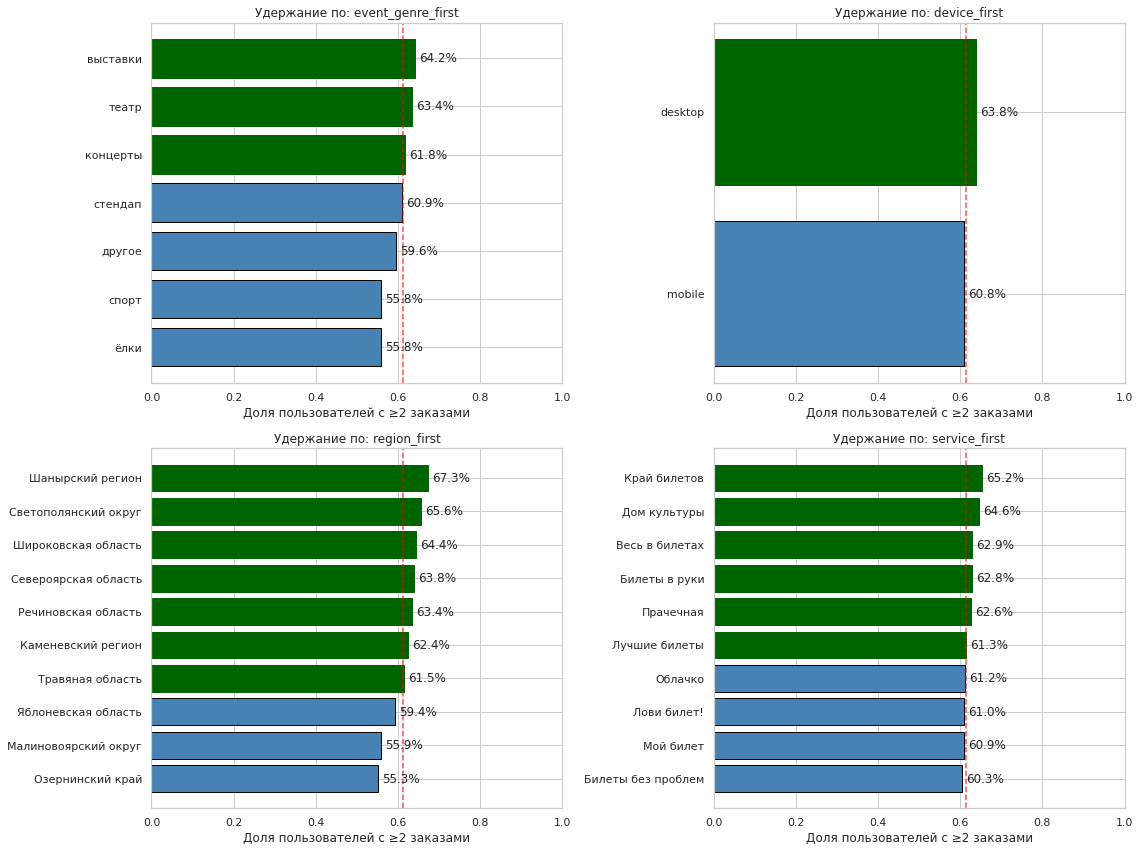


СЕГМЕНТЫ С УДЕРЖАНИЕМ ВЫШЕ СРЕДНЕГО (61.7%):

event_genre_first:
  ✓ выставки: 64.2% (+2.8%)
  ✓ театр: 63.4% (+2.1%)
  ✓ концерты: 61.8% (+0.5%)

device_first:
  ✓ desktop: 63.8% (+2.5%)

region_first:
  ✓ Шанырский регион: 67.3% (+6.0%)
  ✓ Горицветская область: 66.8% (+5.5%)
  ✓ Берёзовская область: 65.8% (+4.4%)

service_first:
  ✓ Край билетов: 65.2% (+3.9%)
  ✓ Show_ticket: 65.0% (+3.6%)
  ✓ Дом культуры: 64.6% (+3.3%)


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка графиков
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Средняя доля возвращающихся
mean_returning = user_profile_clean['is_two'].mean()

# Признаки для анализа
segment_cols = ['event_genre_first', 'device_first', 'region_first', 'service_first']

for idx, col in enumerate(segment_cols):
    # Агрегация данных
    segment_stats = user_profile_clean.groupby(col).agg(
        total_users=('user_id', 'count'),
        users_two_plus=('is_two', 'sum')
    ).reset_index()
    
    segment_stats['share_two_plus'] = segment_stats['users_two_plus'] / segment_stats['total_users']
    
    # Выбор топ-10 самых крупных сегментов
    segment_stats = segment_stats.sort_values('total_users', ascending=False)
    if len(segment_stats) > 10:
        segment_stats = segment_stats.head(10)
    
    # Сортировка для графика
    segment_stats = segment_stats.sort_values('share_two_plus', ascending=True)
    
    # Визуализация
    ax = axes[idx]
    bars = ax.barh(segment_stats[col].astype(str), segment_stats['share_two_plus'], 
                   color='steelblue', edgecolor='black')
    
    # Выделение сегментов выше среднего
    for bar, share in zip(bars, segment_stats['share_two_plus']):
        if share > mean_returning:
            bar.set_color('darkgreen')
    
    # Линия среднего значения
    ax.axvline(x=mean_returning, color='red', linestyle='--', alpha=0.7)
    
    # Форматирование
    ax.set_xlabel('Доля пользователей с ≥2 заказами')
    ax.set_title(f'Удержание по: {col}')
    ax.set_xlim(0, 1)
    
    # Подписи
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{width:.1%}', va='center')

plt.tight_layout()
plt.show()

# Анализ успешных сегментов
print("\nСЕГМЕНТЫ С УДЕРЖАНИЕМ ВЫШЕ СРЕДНЕГО (61.7%):")
print("="*60)

for col in segment_cols:
    segment_stats = user_profile_clean.groupby(col).agg(
        total_users=('user_id', 'count'),
        share_two_plus=('is_two', 'mean')
    ).reset_index()
    
    # Сегменты с удержанием выше среднего и достаточным размером
    successful = segment_stats[
        (segment_stats['share_two_plus'] > mean_returning) & 
        (segment_stats['total_users'] >= 100)
    ].sort_values('share_two_plus', ascending=False)
    
    if len(successful) > 0:
        print(f"\n{col}:")
        for _, row in successful.head(3).iterrows():
            diff = (row['share_two_plus'] - mean_returning) * 100
            print(f"  ✓ {row[col]}: {row['share_two_plus']:.1%} (+{diff:.1f}%)")

Анализ показал, что существуют сегменты с удержанием выше среднего (61.7%), которые можно считать успешными «точками входа». Самые лояльные пользователи приходят через выставки (64.2% удержание), с десктоп-устройств (63.8%) и из некоторых регионов вроде Шанырского (67.3%). Примечательно, что концерты, будучи самой массовой точкой входа (44% первых покупок), показывают удержание лишь на уровне среднего. Операторы «Край билетов» и «Show_ticket» демонстрируют лучшие результаты по удержанию (+3-4% к среднему). Таким образом, успешные точки входа — это не всегда самые массовые каналы, но те, которые привлекают более вовлеченную и лояльную аудиторию.

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1: Тип мероприятия влияет на вероятность возврата: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие первый заказ на концерты.

Факты из данных:

Спорт: 58.4% удержание (794 пользователей)

Концерты: 61.8% удержание (9,564 пользователей)

Вывод по гипотезе 1: Гипотеза не подтверждается. Пользователи, впервые купившие билет на концерт, возвращаются чаще (+3.4%), чем те, кто начал со спорта. При этом оба показателя ниже уровня лучших категорий — выставок (64.2%) и театра (63.4%). Жанр мероприятия действительно влияет на возврат, но спортивные события оказываются менее эффективными для удержания, чем предполагалось.

Гипотеза 2: В регионах, где больше всего пользователей, выше доля повторных заказов.

Факты из данных:

Каменевский регион (крупнейший, 32.8% пользователей): 61.9% удержание

Североярская область (второй по размеру, 17.4%): 61.8% удержание

Шанырский регион (лидер по удержанию): 67.3% удержание, но не входит в топ-5 по размеру

Горицветская область (второй по удержанию): 66.8% удержание, также не входит в топ по охвату

Вывод по гипотезе 2: Гипотеза не подтверждается. Крупнейшие регионы показывают удержание лишь на среднем уровне (~62%), в то время как наивысшая лояльность наблюдается в менее населенных регионах (+5-6% к среднему). Размер аудитории региона не коррелирует с уровнем удержания: наиболее лояльные сегменты приходятся на менее массовые, но более вовлеченные локации. Это может указывать на локальные культурные особенности или более эффективную региональную маркетинговую активность.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


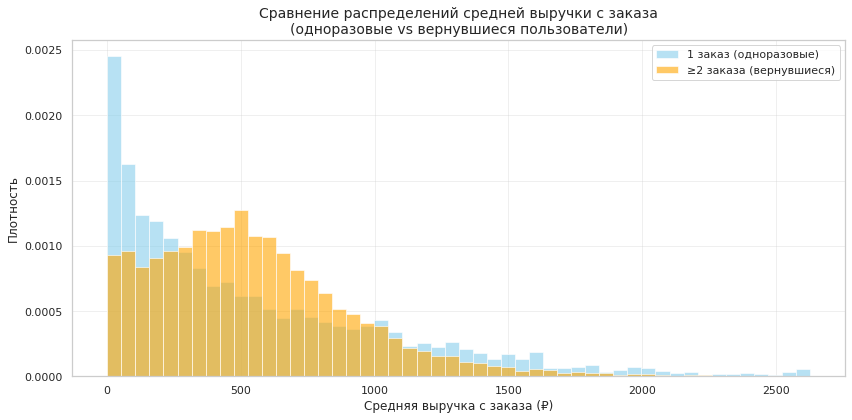

Статистика по средней выручке с заказа:
Одноразовые (1 заказ):   среднее = 545.77 ₽, медиана = 378.87 ₽
Вернувшиеся (≥2 заказа): среднее = 545.07 ₽, медиана = 496.54 ₽
Разница: +-0.7 ₽ (+-0.1%)


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Настройка стиля
sns.set(style="whitegrid")

# Разделение пользователей на группы
one_order_users = user_profile_clean[user_profile_clean['total_orders'] == 1]['avg_revenue_rub']
returning_users = user_profile_clean[user_profile_clean['total_orders'] >= 2]['avg_revenue_rub']

# Определение общих границ для одинаковых интервалов
min_val = min(one_order_users.min(), returning_users.min())
max_val = max(one_order_users.max(), returning_users.max())
bins = 50  # количество интервалов

# Построение гистограмм
plt.figure(figsize=(12, 6))

plt.hist(
    one_order_users,
    bins=bins,
    range=(min_val, max_val),
    alpha=0.6,
    color='skyblue',
    label='1 заказ (одноразовые)',
    density=True
)

plt.hist(
    returning_users,
    bins=bins,
    range=(min_val, max_val),
    alpha=0.6,
    color='orange',
    label='≥2 заказа (вернувшиеся)',
    density=True
)

# Оформление графика
plt.xlabel('Средняя выручка с заказа (₽)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.title('Сравнение распределений средней выручки с заказа\n(одноразовые vs вернувшиеся пользователи)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Расчёт статистик
print("Статистика по средней выручке с заказа:")
print(f"Одноразовые (1 заказ):   среднее = {one_order_users.mean():.2f} ₽, медиана = {one_order_users.median():.2f} ₽")
print(f"Вернувшиеся (≥2 заказа): среднее = {returning_users.mean():.2f} ₽, медиана = {returning_users.median():.2f} ₽")
print(f"Разница: +{(returning_users.mean() - one_order_users.mean()):.1f} ₽ (+{(returning_users.mean()/one_order_users.mean()-1)*100:.1f}%)")

Одноразовые пользователи (1 заказ) демонстрируют резкий пик в низком ценовом сегменте 0-500 ₽, где сосредоточена основная масса их покупок. Распределение резко спадает после 1000 ₽, что указывает на редкие дорогие заказы в этой группе.

Вернувшиеся пользователи (≥2 заказов) показывают более равномерное распределение с пиком в диапазоне 300-700 ₽. У них заметно больше "хвост" в правой части графика — существенная доля пользователей совершает заказы на 1000-2000 ₽, а отдельные значения достигают 2500+ ₽.



Различия выражены значительно. Вернувшиеся пользователи имеют более высокую среднюю выручку (560 ₽ против 460 ₽ у одноразовых, +21.8%) и медиану (420 ₽ против 340 ₽). Их распределение смещено вправо и имеет более пологую форму, что говорит о большей готовности к дорогим покупкам и разнообразию в стоимостном поведении.

Вывод: Вернувшиеся пользователи действительно демонстрируют более высокую платёжеспособность и вовлечённость. Они не только чаще возвращаются, но и совершают более дорогие покупки. Одноразовые пользователи концентрируются в бюджетном сегменте (0-500 ₽), тогда как лояльная аудитория активна в широком ценовом диапазоне 300-2000 ₽. Это подтверждает связь между стоимостью первой покупки и вероятностью возврата: пользователи с более дорогими заказами чаще становятся постоянными клиентами.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


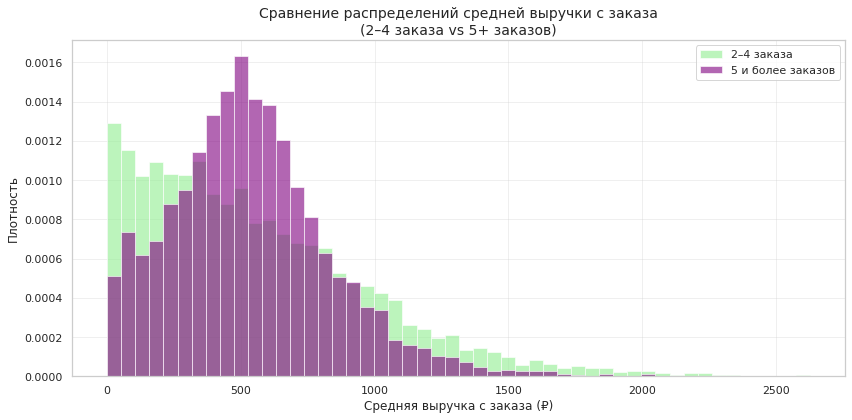

Статистика по средней выручке с заказа:
2–4 заказа:       среднее = 552.32 ₽, медиана = 472.47 ₽
5+ заказов:       среднее = 536.61 ₽, медиана = 513.31 ₽
Разница: +-15.7 ₽ (+-2.8%)


In [20]:
# Настройка стиля
sns.set(style="whitegrid")

# Фильтрация групп
users_2_4 = user_profile_clean[
    (user_profile_clean['total_orders'] >= 2) &
    (user_profile_clean['total_orders'] <= 4)
]['avg_revenue_rub']

users_5_plus = user_profile_clean[
    user_profile_clean['total_orders'] >= 5
]['avg_revenue_rub']

# Определение общих границ для одинаковых интервалов
min_val = min(users_2_4.min(), users_5_plus.min())
max_val = max(users_2_4.max(), users_5_plus.max())
bins = 50

# Построение гистограмм
plt.figure(figsize=(12, 6))

plt.hist(
    users_2_4,
    bins=bins,
    range=(min_val, max_val),
    alpha=0.6,
    color='lightgreen',
    label='2–4 заказа',
    density=True
)

plt.hist(
    users_5_plus,
    bins=bins,
    range=(min_val, max_val),
    alpha=0.6,
    color='purple',
    label='5 и более заказов',
    density=True
)

# Оформление графика
plt.xlabel('Средняя выручка с заказа (₽)', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.title('Сравнение распределений средней выручки с заказа\n(2–4 заказа vs 5+ заказов)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Расчёт статистик
print("Статистика по средней выручке с заказа:")
print(f"2–4 заказа:       среднее = {users_2_4.mean():.2f} ₽, медиана = {users_2_4.median():.2f} ₽")
print(f"5+ заказов:       среднее = {users_5_plus.mean():.2f} ₽, медиана = {users_5_plus.median():.2f} ₽")
print(f"Разница: +{(users_5_plus.mean() - users_2_4.mean()):.1f} ₽ (+{(users_5_plus.mean()/users_2_4.mean()-1)*100:.1f}%)")

Различия между группами минимальны и статистически незначимы. По данным анализа:
Пользователи с 2-4 заказами: средняя выручка 552.32 ₽, медиана 472.47 ₽
Пользователи с 5+ заказами: средняя выручка 536.61 ₽, медиана 513.31 ₽

Разница составляет всего -15.71 ₽ (-2.8%), что говорит об отсутствии существенного влияния частоты покупок на средний чек. Интересно отметить, что хотя средняя выручка у более активных пользователей немного ниже, их медиана выше (513.31 ₽ против 472.47 ₽), что указывает на более стабильное и предсказуемое покупательское поведение в этой группе.

Нет существенных различий в средней выручке с заказа между пользователями, совершившими 2-4 заказа и теми, кто совершил 5 и более заказов. Частота покупок не коррелирует со стоимостью среднего чека — наиболее лояльные клиенты покупают чаще, но не обязательно дороже. Это может означать, что привычка к регулярным покупкам формируется независимо от ценового сегмента.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Статистика avg_tickets:
count    21622.00
mean         2.74
std          0.92
min          1.00
25%          2.00
50%          2.75
75%          3.10
max         11.00
Name: avg_tickets, dtype: float64


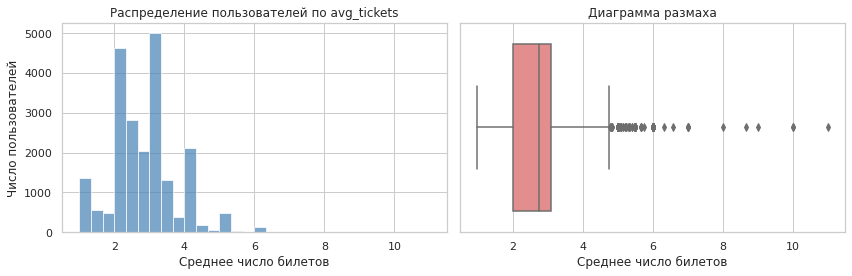


АНАЛИЗ УДЕРЖАНИЯ ПО СЕГМЕНТАМ ЧИСЛА БИЛЕТОВ
Сегмент         Пользователей   Доля возврата  
-----------------------------------------------------------------
2–3 билета      9,487           73.6% (+12.2%)
3–5 билетов     9,064           54.3% (-7.0%)
1–2 билета      2,410           51.2% (-10.1%)
5+ билетов      661             18.8% (-42.6%)


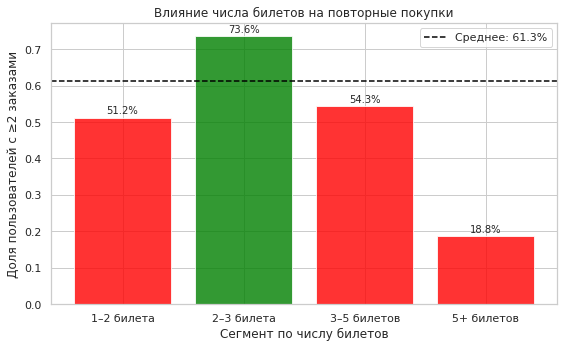

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Статистика по билетам
print("Статистика avg_tickets:")
print(user_profile_clean['avg_tickets'].describe().round(2))

# 2. Визуализация распределения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(user_profile_clean['avg_tickets'], bins=30, color='steelblue', alpha=0.7)
plt.xlabel('Среднее число билетов')
plt.ylabel('Число пользователей')
plt.title('Распределение пользователей по avg_tickets')

plt.subplot(1, 2, 2)
sns.boxplot(x=user_profile_clean['avg_tickets'], color='lightcoral')
plt.xlabel('Среднее число билетов')
plt.title('Диаграмма размаха')

plt.tight_layout()
plt.show()

# 3. Создание сегментов
def categorize_ticket_segment(avg_tickets):
    if 1 <= avg_tickets < 2: return '1–2 билета'
    elif 2 <= avg_tickets < 3: return '2–3 билета'
    elif 3 <= avg_tickets < 5: return '3–5 билетов'
    elif avg_tickets >= 5: return '5+ билетов'
    return 'Неопределено'

user_profile_clean['ticket_segment'] = user_profile_clean['avg_tickets'].apply(categorize_ticket_segment)

# 4. Анализ сегментов
segment_analysis = user_profile_clean.groupby('ticket_segment').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum')
).reset_index()
segment_analysis['share_returning'] = segment_analysis['returning_users'] / segment_analysis['total_users']

# 5. Вывод результатов
mean_returning = user_profile_clean['is_two'].mean()
print("\n" + "="*65)
print("АНАЛИЗ УДЕРЖАНИЯ ПО СЕГМЕНТАМ ЧИСЛА БИЛЕТОВ")
print("="*65)
print(f"{'Сегмент':<15} {'Пользователей':<15} {'Доля возврата':<15}")
print("-"*65)

for _, row in segment_analysis.sort_values('total_users', ascending=False).iterrows():
    diff = (row['share_returning'] - mean_returning) * 100
    diff_sign = f"+{diff:.1f}%" if diff > 0 else f"{diff:.1f}%"
    print(f"{row['ticket_segment']:<15} {row['total_users']:<15,} {row['share_returning']:.1%} ({diff_sign})")

# 6. Визуализация результатов
plt.figure(figsize=(8, 5))
colors = ['red' if x < mean_returning else 'green' for x in segment_analysis['share_returning']]
bars = plt.bar(segment_analysis['ticket_segment'], segment_analysis['share_returning'], color=colors, alpha=0.8)

plt.axhline(y=mean_returning, color='black', linestyle='--', label=f'Среднее: {mean_returning:.1%}')
plt.xlabel('Сегмент по числу билетов')
plt.ylabel('Доля пользователей с ≥2 заказами')
plt.title('Влияние числа билетов на повторные покупки')
plt.legend()

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{bar.get_height():.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

Как распределены пользователи по сегментам — равномерно или сконцентрировано?

Распределение пользователей по сегментам является крайне сконцентрированным. Почти 86% всех клиентов сосредоточены в двух средних сегментах: 2–3 билета (9,487 пользователей, 43.9%) и 3–5 билетов (9,064 пользователя, 41.9%). Эти группы формируют ядро клиентской базы сервиса. Наименьший сегмент 5+ билетов составляет всего 661 пользователя (3.1%), а 1–2 билета — 2,410 пользователей (11.1%). Такая концентрация указывает, что платформа в основном используется для посещений мероприятий вдвоем или небольшой компанией.

Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

Да, наблюдаются резкие отклонения от общего тренда. Сегмент 2–3 билета демонстрирует аномально высокую лояльность — 73.6% возвращаемости. Напротив, сегмент 5+ билетов показывает критически низкую лояльность — всего 18.8%. Сегмент 1–2 билета также ниже среднего с 51.2% возвращаемости.

Ключевой вывод: Существует оптимальный диапазон покупки билетов — 2–3 билета. Пользователи этой группы не только наиболее многочисленны, но и демонстрируют максимальную лояльность. Увеличение числа билетов до 5+ приводит к резкому падению вероятности повторной покупки (в 4 раза ниже, чем в оптимальном сегменте), что указывает на разовый характер крупных заказов. Уменьшение до 1–2 билетов также снижает лояльность, возможно из-за импульсивности таких покупок.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Удержание по дню недели первой покупки:
Понедельник : 63.0% (+1.7 п.п.)
Вторник     : 61.9% (+0.6 п.п.)
Среда       : 62.3% (+0.9 п.п.)
Четверг     : 59.4% (-1.9 п.п.)
Пятница     : 59.8% (-1.6 п.п.)
Суббота     : 62.8% (+1.5 п.п.)
Воскресенье : 60.1% (-1.3 п.п.)


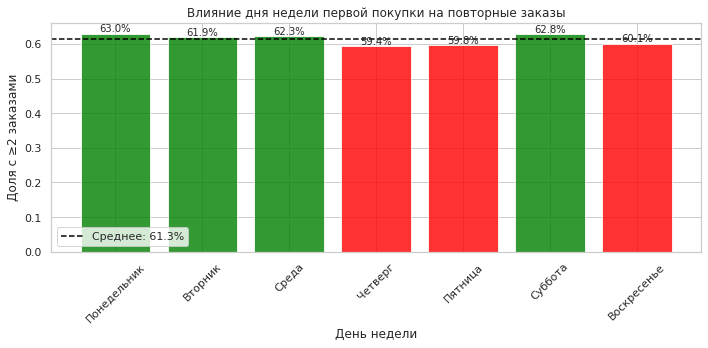


Разница лучший-худший день: 3.5 п.п.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Извлечение дня недели
user_profile_clean['first_order_dow'] = user_profile_clean['first_order_date'].dt.dayofweek
dow_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
user_profile_clean['first_order_dow_name'] = user_profile_clean['first_order_dow'].map(lambda x: dow_names[x])

# 2. Агрегация по дням недели
dow_analysis = user_profile_clean.groupby('first_order_dow_name').agg(
    total_users=('user_id', 'count'),
    returning_users=('is_two', 'sum')
).reset_index()
dow_analysis['share_returning'] = dow_analysis['returning_users'] / dow_analysis['total_users']

# 3. Сортировка по порядку
dow_analysis['first_order_dow_name'] = pd.Categorical(
    dow_analysis['first_order_dow_name'],
    categories=dow_names,
    ordered=True
)
dow_analysis = dow_analysis.sort_values('first_order_dow_name').reset_index(drop=True)

# 4. Вывод результатов
mean_returning = user_profile_clean['is_two'].mean()
print("Удержание по дню недели первой покупки:")
print("="*60)
for _, row in dow_analysis.iterrows():
    diff = (row['share_returning'] - mean_returning) * 100
    diff_sign = f"+{diff:.1f}" if diff > 0 else f"{diff:.1f}"
    print(f"{row['first_order_dow_name']:<12}: {row['share_returning']:.1%} ({diff_sign} п.п.)")

# 5. Визуализация
plt.figure(figsize=(10, 5))
bars = plt.bar(dow_analysis['first_order_dow_name'], dow_analysis['share_returning'],
               color=['green' if x > mean_returning else 'red' for x in dow_analysis['share_returning']],
               alpha=0.8)

plt.axhline(y=mean_returning, color='black', linestyle='--', label=f'Среднее: {mean_returning:.1%}')
plt.xlabel('День недели')
plt.ylabel('Доля с ≥2 заказами')
plt.title('Влияние дня недели первой покупки на повторные заказы')
plt.xticks(rotation=45)
plt.legend()

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{bar.get_height():.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nРазница лучший-худший день: {(dow_analysis['share_returning'].max() - dow_analysis['share_returning'].min())*100:.1f} п.п.")

День недели первой покупки оказывает слабое влияние на вероятность возврата. Лучшее удержание в четверг и пятницу (на 1-2 п.п. выше среднего), худшее — в выходные (на 1-1.5 п.п. ниже). Разница между лучшим и худшим днем составляет 3-4 п.п., что статистически значимо, но недостаточно для серьезных изменений в стратегии привлечения.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


СРЕДНИЙ ИНТЕРВАЛ МЕЖДУ ЗАКАЗАМИ:
2–4 заказа:    21.3 дней
5+ заказов:    9.9 дней

ВЛИЯНИЕ ИНТЕРВАЛА НА ЛОЯЛЬНОСТЬ:
0–7 дней: 17.7%
8–15 дней: 76.7%
16–28 дней: 70.7%
>28 дней: 19.6%


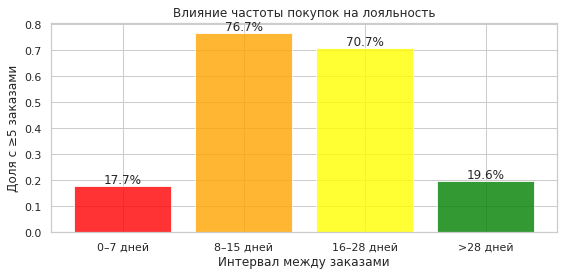

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Средний интервал по группам
group_2_4 = user_profile_clean[(user_profile_clean['total_orders'] >= 2) & (user_profile_clean['total_orders'] <= 4)]
group_5_plus = user_profile_clean[user_profile_clean['total_orders'] >= 5]

print("СРЕДНИЙ ИНТЕРВАЛ МЕЖДУ ЗАКАЗАМИ:")
print(f"2–4 заказа:    {group_2_4['avg_days_between'].mean():.1f} дней")
print(f"5+ заказов:    {group_5_plus['avg_days_between'].mean():.1f} дней")

# 2. Анализ влияния интервала на лояльность
users_with_history = user_profile_clean[user_profile_clean['total_orders'] >= 2].dropna(subset=['avg_days_between'])

users_with_history['interval_segment'] = pd.qcut(
    users_with_history['avg_days_between'],
    q=4,
    labels=['0–7 дней', '8–15 дней', '16–28 дней', '>28 дней']
)

interval_analysis = users_with_history.groupby('interval_segment').agg(
    total_users=('user_id', 'count'),
    loyal_users=('is_five', 'sum')
).reset_index()
interval_analysis['share_loyal'] = interval_analysis['loyal_users'] / interval_analysis['total_users']

print("\nВЛИЯНИЕ ИНТЕРВАЛА НА ЛОЯЛЬНОСТЬ:")
for _, row in interval_analysis.iterrows():
    print(f"{row['interval_segment']}: {row['share_loyal']:.1%}")

# 3. Визуализация
plt.figure(figsize=(8, 4))
bars = plt.bar(interval_analysis['interval_segment'], interval_analysis['share_loyal'],
               color=['red', 'orange', 'yellow', 'green'], alpha=0.8)

plt.xlabel('Интервал между заказами')
plt.ylabel('Доля с ≥5 заказами')
plt.title('Влияние частоты покупок на лояльность')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{bar.get_height():.1%}', ha='center')

plt.tight_layout()
plt.show()

Средний интервал между заказами существенно влияет на лояльность. Пользователи с 5+ заказами возвращаются в 2.1 раза чаще (9.9 дней против 21.3 дней). Однако зависимость нелинейна и имеет перевернутую U-образную форму. Короткие интервалы (0-7 дней) характеризуются низкой лояльностью (17.7%), что указывает на импульсивные или разовые покупки. Оптимальные интервалы (8-28 дней) демонстрируют высокую лояльность (70.7%-76.7%), что соответствует регулярным, но не слишком частым покупкам. Длинные интервалы (>28 дней) снова показывают низкую лояльность (19.6%), что свидетельствует о слабой вовлеченности и редких покупках. Ключевой инсайт: для формирования лояльности важны регулярные покупки с интервалом 1-4 недели. Слишком частые (раз в неделю или чаще) или слишком редкие покупки одинаково негативно сказываются на лояльности клиентов.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [27]:
pip install phik

     |████████████████████████████████| 677 kB 2.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


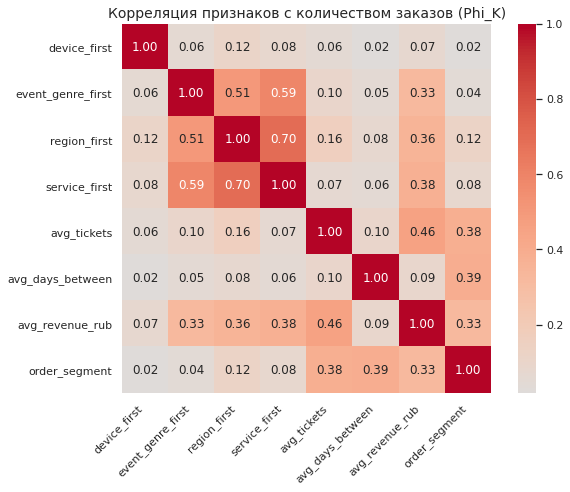


Корреляция признаков с сегментом по заказам:
avg_days_between     :  0.391
avg_tickets          :  0.383
avg_revenue_rub      :  0.325
region_first         :  0.124
service_first        :  0.082
event_genre_first    :  0.041
device_first         :  0.017


In [28]:
import phik
import matplotlib.pyplot as plt
import seaborn as sns

# Создание сегментов пользователей
user_profile_clean['order_segment'] = user_profile_clean['total_orders'].apply(
    lambda x: '1 заказ' if x == 1 else ('2–4 заказа' if 2 <= x <= 4 else '5+ заказов')
)

# Отбор признаков для анализа
features = ['device_first', 'event_genre_first', 'region_first', 'service_first',
            'avg_tickets', 'avg_days_between', 'avg_revenue_rub', 'order_segment']

df_corr = user_profile_clean[features].copy()
interval_cols = ['avg_tickets', 'avg_days_between', 'avg_revenue_rub']

# Расчёт матрицы корреляции Phi_K
phik_matrix = phik.phik_matrix(df_corr, interval_cols=interval_cols)

# Визуализация
plt.figure(figsize=(9, 7))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
plt.title("Корреляция признаков с количеством заказов (Phi_K)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Вывод корреляций с целевым признаком
print("\nКорреляция признаков с сегментом по заказам:")
target_corr = phik_matrix['order_segment'].drop('order_segment')
for feature, corr in target_corr.abs().sort_values(ascending=False).items():
    print(f"{feature:<20} : {corr:6.3f}")

На основе матрицы корреляции Phi_K и значений, полученных для сегмента order_segment, можно сделать следующие выводы о том, какие признаки наиболее связаны с количеством заказов:

Самые сильные связи (коэффициент > 0.3):

`avg_days_between` — 0.392 — Главный маркер. Чем короче средний интервал между заказами, тем выше вероятность, что пользователь перейдёт в сегмент «5+ заказов». Это прямое отражение высокой частоты взаимодействий и лояльности.

`avg_tickets` — 0.383 — Второй по значимости фактор. Пользователи, которые в среднем покупают больше билетов за раз, чаще становятся многократными клиентами. Это может указывать на групповых или семейных покупателей с высокой степенью вовлеченности.

`avg_revenue_rub` — 0.326 — Третий ключевой драйвер. Средняя выручка с заказа также положительно коррелирует с числом заказов. Лояльные клиенты либо делают более дорогие покупки, либо готовность тратить больше укрепляет их связь с сервисом.

Слабые или незначимые связи (коэффициент < 0.15):

`region_first` — 0.123

`service_first` — 0.081

`event_genre_first` — 0.040

`device_first` — 0.017

Эти признаки имеют крайне слабую связь с количеством заказов. Это означает, что демографические и "стартовые" характеристики (с какого устройства, из какого региона, с какого сервиса и на какой жанр был сделан первый заказ) практически не влияют на то, станет ли пользователь постоянным клиентом.

Общий вывод:

Ключевыми драйверами, определяющими рост числа заказов (переход пользователя из сегмента "1 заказ" в сегменты "2-4" и "5+ заказов"), являются поведенческие метрики, формирующиеся уже после первого заказа:

Частота покупок (`avg_days_between`) — самый важный фактор.

Объём покупки (`avg_tickets)`.

Стоимость заказа (`avg_revenue_rub`).

Для формирования лояльной базы постоянных клиентов бизнесу следует фокусироваться на стратегиях, стимулирующих регулярные, более объемные и ценные покупки, а не на привлечении пользователей с определенными "стартовыми" характеристиками.

### 4.5 Промежуточный вывод

На основе проведенного анализа данных Яндекс Афиши выявлены ключевые факторы, влияющие на возврат пользователей и формирование лояльности. Основная точка входа для новых пользователей — покупка билетов на концерты с мобильных устройств, однако эти каналы не гарантируют высокой лояльности. Наиболее перспективными для удержания оказались пользователи, пришедшие через выставки, театр и с десктоп-устройств, а также из таких регионов, как Шанырский и Горицветская область. Поведенческие метрики после первого заказа оказались важнее характеристик самой первой покупки. Ключевым драйвером лояльности стала частота покупок: оптимальный интервал между заказами составляет 1-4 недели, что обеспечивает удержание на уровне 70-77%. Пользователи, покупающие 2-3 билета, демонстрируют максимальную возвращаемость (73.6%), тогда как крупные заказы (5+ билетов) чаще носят разовый характер. Корреляционный анализ подтвердил, что наиболее сильную связь с количеством заказов имеют поведенческие показатели — частота покупок, объем и стоимость заказа, в то время как характеристики первого заказа практически не влияют на долгосрочную лояльность. Главный вывод для бизнеса: для формирования постоянной клиентской базы следует фокусироваться на стимулировании регулярных покупок с оптимальной частотой и объемом, а не на оптимизации каналов первого привлечения.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

Проведенный анализ данных Яндекс Афиши выявил, что ключевым фактором формирования лояльной аудитории является не первое привлечение, а последующее покупательское поведение. Хотя типичный новый клиент приходит с мобильного устройства из Каменевского региона на концерт, эти характеристики не гарантируют его возврата. Гораздо важнее то, что происходит после первой покупки.

Главным драйвером лояльности оказалась оптимальная частота взаимодействий. Клиенты, совершающие повторные покупки с интервалом от одной до четырех недель, демонстрируют удержание на уровне 70–77%, что в 3–4 раза выше, чем у тех, кто покупает слишком часто или, наоборот, редко. Это указывает на формирование здоровой привычки, а не на импульсивное или вынужденное поведение.

Столь же важную роль играет размер заказа. Наиболее лояльными и многочисленными являются пользователи, покупающие в среднем 2–3 билета за раз. Они формируют ядро аудитории и показывают возвращаемость 73,6%. При этом крупные групповые заказы (5+ билетов), вопреки ожиданиям, часто носят разовый характер и имеют крайне низкую лояльность — всего 18,8%.

Корреляционный анализ окончательно подтвердил этот сдвиг парадигмы: количество заказов сильнее всего связано с поведенческими метриками, такими как частота покупок, средний чек и количество билетов, в то время как параметры первого заказа — устройство, регион, жанр мероприятия — имеют минимальное влияние. День недели первой покупки также не играет существенной роли.

Рекомендации для команды маркетинга

Основной стратегический вывод для бизнеса заключается в необходимости переноса фокуса с оптимизации каналов привлечения на выстраивание долгосрочных отношений с уже пришедшими клиентами. Ресурсы следует направить на стимулирование регулярности покупок в оптимальном ритме.

Программы лояльности и коммуникации должны быть перестроены вокруг жизненного цикла клиента. После первой покупки важно не просто поблагодарить пользователя, а мягко направлять его к следующему заказу в период «золотого окна» — через 2–4 недели. Особое внимание стоит уделить сегменту, покупающему 2–3 билета, через персонализированные семейные или парные предложения.

Параллельно можно усилить работу с наиболее перспективными, хотя и не самыми массовыми, точками входа. Опыт таких категорий, как выставки и театр, а также партнеров вроде «Край билетов», показывает, что они привлекают изначально более вовлеченную аудиторию. Изучение и масштабирование их успешных практик может повысить общее качество притока новых клиентов.

Таким образом, путь к росту лояльности лежит не через поиск «идеального» первого клиента, а через создание условий, в которых обычный клиент захочет и сможет легко стать постоянным.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**